# 1. Newsgroup dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. In this assignment we are going to use a **subset** of this dataset to learn a bit about unsupervised learning methods in machine learning. To load this dataset we are going to use scikit-learn library which you have worked with a couple of times through semester.

# 2. Loading data and preprocessing

To ensure that your results are reproducable make sure to set the seed value.

In [2]:
import numpy as np
import pandas as pd
SEED = 123
np.random.seed(SEED)

## 2.1. downloading and loading data

You can download both training set and test set separately using sklearn apis. [Here](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) you can find sample codes for loading dataset.

In [3]:
from sklearn.datasets import fetch_20newsgroups

def bunch_to_df(_bunch):
    d = {'data' : _bunch.data, 'target' : _bunch.target}
    return pd.DataFrame(data = d)

# YOUR CODE HERE
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

## 2.2 filtering target classes

Explore dataset and get familiar with it. Then, implement `filter_split_x_y` function which extracts `selected_targets` classes from data and splits the data into two lists of X and ys. Please don't change `selected_targets` list is this cell.

In [4]:

selected_targets = [1, 7, 10, 13, 15, 16, 17]

def filter_split_X_y(raw_data, selected_targets):
    """
    This function inputs a newsgroup dataset and filters it based on your selected labels
    then returns two lists of datapoints and labels separately
    
    """
    # YOUR CODE HERE
    df = bunch_to_df(raw_data)
    temp = df[df['target'].isin(selected_targets)]
    X = temp['data']
    y = temp['target']
    return X,y

train_x, train_y = filter_split_X_y(newsgroups_train, selected_targets)
test_x, test_y = filter_split_X_y(newsgroups_test, selected_targets)

**2.2.1.** Print the name of classes in your training set along with `selected_targets` you can use `target_names` attribute of `newsgroups_train`. Make sure you include this output in your PDF report.

1 comp.graphics
7 rec.autos
10 rec.sport.hockey
13 sci.med
15 soc.religion.christian
16 talk.politics.guns
17 talk.politics.mideast

In [5]:
for target in selected_targets:
    target_name = newsgroups_train.target_names[target]
    print(target, target_name)

1 comp.graphics
7 rec.autos
10 rec.sport.hockey
13 sci.med
15 soc.religion.christian
16 talk.politics.guns
17 talk.politics.mideast


## 2.3. vectorizing documents

There are several ways that one can use to vectorize a whole document. In this programming assignment we are going to use **TF-IDF** method. Please go ahead and watch [this short video](https://www.youtube.com/watch?v=D2V1okCEsiE) to understand how tf-idf works and then answer the following questions.

**2.3.1.** What does TF-IDF stand for?<br>
TF is term frequency which is the number of repetitions of words in a sentence over the number of words in a sentence. IDF is inverse document frequency which is the log of number of sentences over the number of sentences containing the words. <br>
**2.3.2.** Why don't we only use term frequency of the words in a document as its feature vector? what is the benefit of adding inverse document frequency?<br>
The inverse document frequency can be viewed as a measure of rareness, the rarer a term is the higher the IDF score will be. For instance, if a word appears in all the documents, it doesn't provide any valuable information in the learning process and inversely if a word is a rare, its occurrence can give some valuable information. IDF is used to capture this rareness among words occuring in across sentences or documents. <br>
**2.3.3.** Calculate the tf-idf vectors of the following two documents, assuming this is the entire corpus:
![Documents](attachment:./tfidf.png)


Now we are going to use scikit-learn to calculate the tf-idf vectors of each document in our twenty newgroups dataset. Write a function that accepts both `train_x` and `test_x` and returns the tf-idf vectors of them in numpy format.

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_dataset(train_x, test_x):
    """
    returns vectorized numpy array of training and test set
    """
    vectorizer = TfidfVectorizer()
    fit = vectorizer.fit(train_x.str.lower())
    train_vec = fit.transform(train_x.str.lower())
    test_vec = fit.transform(test_x.str.lower())
    return train_vec.toarray(), test_vec.toarray()
    
    
train_vec, test_vec = vectorize_dataset(train_x, test_x)
print(train_vec.shape, test_vec.shape)

(4081, 56153) (2718, 56153)


# 3. dimension reduction

In the previous section we built features vectors for each of the documents. However, these feature vectors are highly sparse and are not easy to cluster or visualize.

## 3.1. Sparsity

Answer these questions to understand the sparsity of these vectors:

**3.1.1** Count the number of non-zeros in each row of the `train_vec` matrix.<br>
**3.1.2** What is the average number non zero elements in each row? <br>
**3.1.3** On average what percentage of elements in each row have non-zero elements?<br>

In [55]:
from scipy import sparse
r = train_vec.shape[0]
c = train_vec.shape[1]

non_zeros = sparse.csr_matrix(train_vec).getnnz(axis=1)
for n in range(len(non_zeros)):
    print('Number of non zero elements in row ' + str(n) + ' is '+ str(non_zeros[n]))
avg_non_zeros = non_zeros.mean()
avg_percent = (non_zeros/c * 100).mean()
print('Average number of non zero elements in each row: {:.2f}'.format(avg_non_zeros))
print('Average percent of non zero elements in each row: {:.2f}'.format(avg_percent))

Number of non zero elements in row 0 is 89
Number of non zero elements in row 1 is 94
Number of non zero elements in row 2 is 217
Number of non zero elements in row 3 is 70
Number of non zero elements in row 4 is 190
Number of non zero elements in row 5 is 636
Number of non zero elements in row 6 is 111
Number of non zero elements in row 7 is 99
Number of non zero elements in row 8 is 221
Number of non zero elements in row 9 is 96
Number of non zero elements in row 10 is 155
Number of non zero elements in row 11 is 281
Number of non zero elements in row 12 is 142
Number of non zero elements in row 13 is 379
Number of non zero elements in row 14 is 155
Number of non zero elements in row 15 is 129
Number of non zero elements in row 16 is 302
Number of non zero elements in row 17 is 214
Number of non zero elements in row 18 is 75
Number of non zero elements in row 19 is 70
Number of non zero elements in row 20 is 119
Number of non zero elements in row 21 is 1163
Number of non zero element

## 3.2. SVD

Use `TruncatedSVD` module in scikit-learn to perform SVD on the dataset. Reduce your dimensions to 3 and perfomr SVD for 100 iterations (**note: the number of iterations parameter is a special component for an alternative way to solve SVD that we did not study in class. You do not need to know what it means**). Make sure to use the random seed given at the beginning of the notebook.

**Note: you should only fit your SVD/UMAP models on train data**

**3.2.1.** What portion of the variance in your dataset is explained by each of the SVD dimensions? <br> 

Portion of variance explained by each component is [0.01618638 0.00617073 0.00540306]


In [56]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

def fit_and_transform_svd(train_vec, test_vec):
    """
    trains a svd model and generate reduced dimension vectros from training and test dataset
    returns: 2 numpy arrays of size <number of documents>*3
    """
    # YOUR CODE
    svd = TruncatedSVD(n_components =3, n_iter = 100, random_state = SEED)
    fit = svd.fit(train_vec)
    train_svd = fit.transform(train_vec)
    test_svd = fit.transform(test_vec)
    print('Portion of variance explained by each component is ' + str(svd.explained_variance_ratio_))
    return train_svd, test_svd
    
train_svd, test_svd = fit_and_transform_svd(sparse.csr_matrix(train_vec), sparse.csr_matrix(test_vec))
train_svd

Portion of variance explained by each component is [0.01618638 0.00617073 0.00540306]


array([[ 2.56476064e-01, -5.40190475e-02,  5.55232002e-02],
       [ 1.39049634e-01, -6.54811253e-02,  4.46990938e-02],
       [ 2.93540873e-01, -9.44683420e-03, -1.30346891e-04],
       ...,
       [ 5.21510101e-01,  6.88511423e-02, -7.25887018e-02],
       [ 2.18741030e-01, -6.02417849e-02, -5.02309250e-03],
       [ 1.91990511e-01, -8.89058464e-02, -5.97458447e-04]])

## 3.3 UMAP

UMAP is another dimensionality reduction method that works in a more complex way. [This video](https://www.youtube.com/watch?v=6BPl81wGGP8) explains on a high level how it performs dimension reduction.
Apply UMAP and get the embeddings for both training and test datasets. Use the previously given `random_state` and reduce dimensions to 3. Also use **cosine similarity** as the similarity metric of UMAP:

- n_components=3
- metric='cosine'
- random_state=SEED
- low_memory=True

In [ ]:
pip install umap-learn

In [57]:
import umap

def fit_and_transform_umap(train_vec, test_vec):
    # YOUR CODE
    _umap = umap.UMAP(n_components = 3, metric = 'cosine', random_state = SEED, low_memory = True)
    fit = _umap.fit(train_vec)
    train_umap = fit.transform(train_vec)
    test_umap = fit.transform(test_vec)
    return train_umap, test_umap
    
train_umap, test_umap = fit_and_transform_umap(sparse.csr_matrix(train_vec), sparse.csr_matrix(test_vec))
train_umap

array([[ 0.25195923, -2.2345076 ,  5.556025  ],
       [ 1.0334486 , -2.8005567 ,  4.230966  ],
       [ 1.5533942 ,  0.01957973,  7.415204  ],
       ...,
       [ 2.7762487 ,  0.6341464 ,  4.704815  ],
       [ 2.4436579 , -3.2358425 ,  8.394627  ],
       [ 0.07376903, -2.8544238 ,  3.502584  ]], dtype=float32)

## 3.4. visualization

install `babyplots` library which provides some nice 3D visaulizations. Then, visualize both of embeddings (SVD and UMAP) of the **training data** using the given function. **make sure you put a screenshot of the visualizations inside your write up**. You can use it to explain your answers to the questions.

<span style="color:red"> Please don't use babyplot inside <b>jupyter lab</b> as it is still not fully supported and produces some errors </span>

Hint: you need to run the function in a separate cell to get the visualization

**3.4.1.** Based on your observation, what is the difference between SVD and UMAP embeddings? 1-2 sentences should suffice.<br>
**3.4.2.** Which one do you prefer to use for a classification task? why? 1-2 sentences should suffice <br>

UMAP can be used for classification as the clusters formed by UMAP are distinct and separated. Also, UMAP can capture any non linear relationship between the features as opposed to SVD. 

In [ ]:
pip install babyplots

In [58]:
from babyplots import Babyplot

def visualize(datapoints, labels):
    bp = Babyplot(background_color="#ffffffff", turntable=True)
    bp.add_plot(
        datapoints,
        "pointCloud",
        "categories",
        np.array(labels).tolist(),
        {
            "colorScale": "Dark2", 
            "showLegend": True
        }
    )
    return bp

In [59]:
visualize(train_umap, train_y)

<IPython.core.display.Javascript object>

In [60]:
visualize(train_svd, train_y)

<IPython.core.display.Javascript object>

# 4. Kmeans clustering



In this part we are going to perform KMeans clustering on the generated embeddings of our training dataset. One major challenge with KMeans is to find the optimum number of clusters to use for clustering. Here, based on our training data, we know that there are 7 clusters in the dataset. However, we want to find the number of optimum clusters solely based on our data. In this part we are going to use [`average silhouette coefficient`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) to evaluate our clustering

## 4.1. clustering and evaluation

**4.1.1** What is the range of possible values of silhouette coefficients? <br>

The silhoutte scores can vary between -1 and 1. <br>

**4.1.2** Describe what a silhouette score of -1 and 1 mean?<br>

A silhouette score of 1 means that the clusters are distinct and well apart from each other, a silhouette score of -1 means that the clusters are assigned in a wrong way. <br>

**4.1.3.** Use `silhouette score` and `KMeans` from sklearn library to find the optimum number of clusters in your `train_umap`. Don't forget to use `SEED` as your kmeans `random_seed`. In order to do this try different values of cluster numbers from 5 to 20. Choose the one that results in the best score. <br>

Model with 11 clusters has the highest silhouette score. <br>

**4.1.4.** Plot silhouette score for different values of `n_clusters` (a plot with `n_clusters` on the x-axis and silhouette score on the y-axis) and find the best value for `n_cluster`. Don't forget to put the plot in your report.

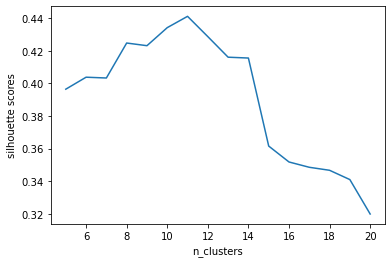

11
Wall time: 9.51 s


In [61]:
%%time

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def get_clustering_scores(train_vectors) -> KMeans:
    """
    This function calculates KMeans model for different values of n_cluster and calculates silhouette score
    for each of them. Then it returns a list of silhouette scores
    RETURNS: 
        list of scores
    """
    # YOUR CODE
    silhouette_scores = []
    for n in range(5,21,1):
        km_clusterer = KMeans(n_clusters=n, random_state=SEED)
        targets = km_clusterer.fit_predict(train_vectors)
        sil_score = silhouette_score(train_vectors, targets)
        silhouette_scores.append(sil_score)
    
    return silhouette_scores


clustering_scores = get_clustering_scores(train_umap)
n_clusters = range(5,21,1)

## plot scores
# YOUR CODE
plt.plot(n_clusters, clustering_scores)
plt.xlabel('n_clusters')
plt.ylabel('silhouette scores')
plt.show()

## Find best number of clusters
# YOUR CODE
print(5 + clustering_scores.index(max(clustering_scores)))

## 4.2. Making a kmeans classifier

Now that we have the best number of clusters, run KMeans again with the best number of clusters associated with the best sihouette score (on `train_umap`). 

After running KMeans you get some number of clusters but each of them have some cluster label that does not necessarily match the trainig labels. Try to implement `get_cluster_mapping` function that inputs your KMeans model and the training labels and returns a dictionary that maps each of the cluster labels to one of the training labels. For example your cluster 0 might correspond to training label of 17.

Hint: In your `get_cluster_mapping` function, find the training label of the majority of data points in each cluster. For example, if your cluster 0 contains 100 data points of label 12 and 5 data points of label 15, the majority of data points in cluster 0 come from label 12. Therefore, your output dictionary should contain the mapping `0: 12`

**4.2.1** show your mapping (resulted dictionary) inside your project report.

In [62]:

# Run KMeans again with best parameter you calculated in the previous section
# YOUR CODE HERE

###
clustering = KMeans(n_clusters=11, random_state=SEED)
clustering.fit(train_umap)

def get_cluster_mapping(clustering: KMeans, original_labels):
    """
    input: a clustering and original labels of the data
    returns: a dictionary that maps each cluster number to an original label
    """
    # YOUR CODE HERE
    clustered_labels = np.unique(clustering.labels_)
    true_labels = np.unique(original_labels)
    rows = len(clustered_labels)
    columns = len(true_labels)
    df = pd.DataFrame(np.zeros((rows, columns)), columns=true_labels)
    for a, b in zip(clustering.labels_, original_labels):
        df.loc[a,b] += 1
    #print(df)
    mapped = df.idxmax(axis=1).tolist()
    ret = {}
    for n in clustered_labels:
        ret[n] = mapped[n]

    return ret

# Feed the generated kmeans clustering and your training labels to the following function
cluster_mapping = get_cluster_mapping(clustering, train_y)
print(cluster_mapping)

{0: 10, 1: 16, 2: 13, 3: 1, 4: 17, 5: 17, 6: 7, 7: 13, 8: 13, 9: 15, 10: 15}


## 4.3. Analyzing clusters

**4.3.1.** Are there any two clusters in your clustering output with the same training label (for example, are there two clusters which both have same training label)? Use your visualizations and describe why?<br>

The clusters (4,5), (7,8) and (9,10) have the same original labels. From the babyplot, the clusters with the original labels of 17, 13 and 15 seem to have subclusters within themselves. This is clear especially in the case of original label 17. These subclusters would have resulted in the overlapping of the original labels. <br>

**4.3.2.** Write the function bellow that returns nearest samples to a cluster center. Use this function and explain why there are overlaps in your labels? <br>

The texts from the subclusters share a common theme hence leading them to have the same original label. But at the same time, the subcluster texts have unique words belonging to the common theme, leading the KMeans algorithm to form two clusters that share the same original label. <br>

**4.3.3.** Can you infere the overlapping label(s) by checking out most central samples? check with original labels.<br>

The most central samples give an idea of why the overlapping occurs, since the central samples give the overall nature of the cluster. We can infer the commonality in the theme of the clusters for which the overlapping occurs and also look at the texts that make them to be classfied as different clusters as opposed to being the same. <br>

In [63]:
from scipy.spatial.distance import cdist

def most_central_samples(clustering: KMeans, cluster_id, k=3):
    """
    returns the text of k most central samples in the specified cluster_id
    """
    # YOUR CODE
    center = clustering.cluster_centers_[cluster_id]
    distances = cdist(train_umap, center.reshape(-1,3)).flatten().tolist()
    sorted_distances = sorted(distances)
    text = []
    for i in range(k):
        min = sorted_distances[i]
        min_idx = distances.index(min)
        text.append(train_x.tolist()[min_idx])
    
    return text

In [64]:
most_central_samples(clustering, 9)

['From: Petch@gvg47.gvg.tek.com (Chuck Petch)\nSubject: Daily Verse\nOrganization: Grass Valley Group, Grass Valley, CA\nLines: 4\n\nLet us not become weary in doing good, for at the proper time we will reap\na harvest if we do not give up. \n\nGalatians 6:9\n',
 'From: Petch@gvg47.gvg.tek.com (Chuck Petch)\nSubject: Daily Verse\nOrganization: Grass Valley Group, Grass Valley, CA\nLines: 6\n\n\n   But someone will say, "You have faith; I have deeds." \n    Show me your faith without deeds, and I will show you my faith by what\nI do. \n\nJames 2:18\n',
 'From: Petch@gvg47.gvg.tek.com (Chuck Petch)\nSubject: Daily Verse\nOrganization: Grass Valley Group, Grass Valley, CA\nLines: 4\n\nHe who overcomes will inherit all this, and I will be his God and he will\nbe my son. \n\nRevelation 21:7\n']

In [65]:
from scipy.spatial.distance import cdist

def most_central_predictions(clustering: KMeans, cluster_id, k=3):
    """
    returns the original labels of k most central samples in the specified cluster_id
    """
    # YOUR CODE
    center = clustering.cluster_centers_[cluster_id]
    distances = cdist(train_umap, center.reshape(-1,3)).flatten().tolist()
    sorted_distances = sorted(distances)
    labels = []
    for i in range(k):
        min = sorted_distances[i]
        min_idx = distances.index(min)
        labels.append(train_y.tolist()[min_idx])
    
    return labels

In [66]:
most_central_predictions(clustering, 5)

[17, 17, 17]

## 4.4. evaluate your kmeans model on test dataset

**4.4.1.** Using the generated mapping, and your clustering model, predict the labels of test dataset (you can use the embeddings of test data that you generated by umap `test_umap`) <br>
**4.4.2.** Calculate the accuracy of model <br>

Accuracy of the model is 0.73 <br>

**4.4.3.** Calculate both micro and macro values of precision, recall and F1 score <br>

********** MICRO SCORES ********** <br>
Precision is 0.73 <br>
Recall is 0.73 <br>
F1 score is 0.73 <br>
********** MACRO SCORES ********** <br>
Precision is 0.80 <br>
Recall is 0.73 <br>
F1 score is 0.74 <br>

In [67]:
# YOUR CODE HERE
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
km_clusterer = KMeans(n_clusters=11, random_state=SEED)
km_clusterer.fit(train_umap)
preds = km_clusterer.predict(test_umap)
mapped_preds = [cluster_mapping[x] for x in preds]
accuracy = accuracy_score(test_y, mapped_preds)
print('Accuracy of the model is {:.2f}'.format(accuracy))
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(test_y, mapped_preds, average='micro')
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(test_y, mapped_preds, average='macro')
print('********** MICRO SCORES **********')
print('Precision is {:.2f}'.format(precision_micro))
print('Recall is {:.2f}'.format(recall_micro))
print('F1 score is {:.2f}'.format(f1_micro))
print('********** MACRO SCORES **********')
print('Precision is {:.2f}'.format(precision_macro))
print('Recall is {:.2f}'.format(recall_macro))
print('F1 score is {:.2f}'.format(f1_macro))

Accuracy of the model is 0.73
********** MICRO SCORES **********
Precision is 0.73
Recall is 0.73
F1 score is 0.73
********** MACRO SCORES **********
Precision is 0.80
Recall is 0.73
F1 score is 0.74


In [68]:
for n in mapped_preds:
    print(n)

10
13
13
15
15
1
17
7
7
17
13
13
13
7
17
1
17
1
7
13
15
16
17
16
13
17
7
13
13
7
17
10
13
15
16
13
16
10
10
15
16
10
17
17
13
10
16
13
10
1
10
13
7
10
10
13
15
10
17
16
7
1
13
7
10
10
16
13
15
16
13
15
13
15
13
13
15
16
1
13
13
13
15
7
10
17
15
15
7
13
13
15
17
10
10
13
1
13
16
15
15
10
13
17
15
13
7
10
13
13
13
13
13
17
16
10
10
13
13
13
13
13
13
10
13
13
13
15
10
1
15
13
10
1
13
10
13
13
15
7
7
13
7
13
15
10
1
1
13
17
13
1
7
1
15
15
16
17
13
13
13
13
13
7
13
13
15
15
13
17
10
10
16
17
13
10
1
16
13
7
10
17
13
17
13
16
13
10
10
15
1
13
13
13
1
17
13
16
10
10
16
1
17
16
13
10
1
16
10
10
1
17
15
17
13
7
16
15
17
7
13
10
13
10
13
10
1
15
17
10
13
10
1
7
10
7
13
13
15
10
13
13
13
15
13
13
15
16
16
16
15
13
10
15
7
13
13
13
10
15
7
17
10
15
16
10
10
7
15
7
7
17
10
10
15
13
1
17
13
13
1
10
15
13
10
17
16
16
1
16
13
17
15
17
16
17
10
13
15
10
10
1
17
1
10
7
13
10
15
10
10
16
13
15
1
16
13
13
13
7
10
10
13
16
13
7
17
15
10
10
13
1
10
17
7
10
15
13
13
13
1
17
17
15
13
17
10
15
13
7
13
13
16
10

# **574 Only** 5.1 KNN classification

Using sklearn `KneighborsClassifier`, classify news data. Then, evaluate your model using the test set.

**5.1.1.** Train two seperate KNN models on both SVD and UMAP embeddings. Use `n_neighbors=100`. <br>
**5.1.2.** Evaluate your model on test datas (`test_umap` and `test_svd`). Which model performs better? Why? <br>

The model based on the UMAP embeddings performs well on the classification task as it has well defined and distinct clustering. <br>

**5.1.3.** Calculate macro and micro precision recall and fscore for `test_umap`. Which one of the two do you prefer for evaluating your model? why? <br>

********** MICRO SCORES ********** <br>
Precision is 0.77 <br>
Recall is 0.77 <br>
F1 score is 0.77 <br>
********** MACRO SCORES ********** <br>
Precision is 0.78 <br>
Recall is 0.77 <br>
F1 score is 0.77 <br>

The macro scores can be used for evaluation as we know that for the newsgroup dataset, the number of articles under each category is roughly uniform. <br>

**5.1.4.** Shortly describe why the two sets of values (macro and micro) are so similar in this case. <br>

The macro and micro average scores are equivalent as there is no class imbalance in the newsgroup dataset that we have selected. In case of a class imbalance, the micro average scores will give a holistic model performance rather than the macro average scores. <br>

In [69]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
knn_classifier = KNeighborsClassifier(n_neighbors=100)
#SVD 
knn_classifier.fit(train_svd, train_y)
svd_preds = knn_classifier.predict(test_svd)
svd_accuracy = accuracy_score(test_y,svd_preds)
svd_precision_micro, svd_recall_micro, svd_f1_micro, _ = precision_recall_fscore_support(test_y, svd_preds, average='micro')
svd_precision_macro, svd_recall_macro, svd_f1_macro, _ = precision_recall_fscore_support(test_y, svd_preds, average='macro')
print('********** SVD **********')
print('Accuracy of the model is {:.2f}'.format(svd_accuracy))
print('********** MICRO SCORES **********')
print('Precision is {:.2f}'.format(svd_precision_micro))
print('Recall is {:.2f}'.format(svd_recall_micro))
print('F1 score is {:.2f}'.format(svd_f1_micro))
print('********** MACRO SCORES **********')
print('Precision is {:.2f}'.format(svd_precision_macro))
print('Recall is {:.2f}'.format(svd_recall_macro))
print('F1 score is {:.2f}'.format(svd_f1_macro))

#UMAP
knn_classifier.fit(train_umap, train_y)
umap_preds = knn_classifier.predict(test_umap)
umap_accuracy = accuracy_score(test_y,umap_preds)
umap_precision_micro, umap_recall_micro, umap_f1_micro, _ = precision_recall_fscore_support(test_y, umap_preds, average='micro')
umap_precision_macro, umap_recall_macro, umap_f1_macro, _ = precision_recall_fscore_support(test_y, umap_preds, average='macro')
print('********** UMAP **********')
print('Accuracy of the model is {:.2f}'.format(umap_accuracy))
print('********** MICRO SCORES **********')
print('Precision is {:.2f}'.format(umap_precision_micro))
print('Recall is {:.2f}'.format(umap_recall_micro))
print('F1 score is {:.2f}'.format(umap_f1_micro))
print('********** MACRO SCORES **********')
print('Precision is {:.2f}'.format(umap_precision_macro))
print('Recall is {:.2f}'.format(umap_recall_macro))
print('F1 score is {:.2f}'.format(umap_f1_macro))

********** SVD **********
Accuracy of the model is 0.47
********** MICRO SCORES **********
Precision is 0.47
Recall is 0.47
F1 score is 0.47
********** MACRO SCORES **********
Precision is 0.48
Recall is 0.47
F1 score is 0.47
********** UMAP **********
Accuracy of the model is 0.77
********** MICRO SCORES **********
Precision is 0.77
Recall is 0.77
F1 score is 0.77
********** MACRO SCORES **********
Precision is 0.78
Recall is 0.77
F1 score is 0.77
